<a href="https://colab.research.google.com/github/yuki-koizumi/seeds-2021/blob/main/SEEDS_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリーの読み込み
機械学習やグラフ描画ライブラリーなど、必要なライブラリーを読み込みます。

In [41]:
import sys

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# 定数値の設定
後続のプログラムで動作を変化させる可能のある値については、以下の変数で定義しています。
必要に応じて、修正してください。

In [42]:
epochs = 10
batch_size = 1024
num_neuron = 1024
num_layer = 5
activation = "relu"

file_name = "FIB1.csv"  # rename this variable if you want to use a different dataset

# データファイルのダウンロード

In [43]:
!if [[ ! -e 'FIB1.csv' ]]; then wget 'https://www-hasegawa.ist.osaka-u.ac.jp/~ykoizumi/FIB1.csv'; fi

# 関数群の定義

In [44]:
def normalize(x, axis=None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd = np.std(x, axis=axis, keepdims=True)
    zscore = (x - xmean) / xstd
    return xmean, xstd, zscore


def denormalize(xmean, xstd, zscore):
    x = zscore * xstd + xmean
    return x


# 学習
def train_model(x, y, model, epochs, batch_size):
    # early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    # history = model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split = 0.1, verbose=1, callbacks=[early_stop])
    # history = model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split = 0.1, verbose=1)
    history = model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=1)
    return model, history


# モデル作成
def build_model(num_neuron, num_layer, activation = "relu"):
    model = keras.Sequential()
    model.add(layers.Dense(num_neuron, input_shape=(1,), activation=activation))
    for i in range(num_layer - 1):
        model.add(layers.Dense(num_neuron, activation=activation))
    model.add(layers.Dense(1))

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])
    return model


def load_data(file_name):
    data = pd.read_csv(file_name).sort_values("IP")
    data = data[~data.duplicated(subset="IP")]
    data = data.reset_index()
    data["position"] = data.index.values
    return np.array(data["IP"]), np.array(data["position"])

def plot_history(history):
    figure_width = 10
    figure_height = figure_width / 1.6180
    marker_size = 10
    line_width = 2
    plt.rcParams["font.size"] = 16
    plt.rcParams["xtick.direction"] = "in"
    plt.rcParams["ytick.direction"] = "in"
    plt.rcParams["axes.linewidth"] = 1.0
    plt.rcParams["pdf.fonttype"] = 42

    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    fig = plt.figure(figsize=(figure_width, figure_height))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(hist["epoch"], hist["mse"], label="Train Error")
    # ax.plot(hist["epoch"], hist["val_mse"], label="Val Error")

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Mean Square Error [$y^2$]")

    ax.set_xlim(0,)
    ax.set_ylim(0,)

    # plt.legend(
    #     bbox_to_anchor=(0, 1),
    #     loc="upper left",
    #     frameon=False,
    #     borderaxespad=0,
    #     labelspacing=0.1,
    # )

    # fig.savefig("fig-history.pdf")
    return


def plot_result(x_orig, y_orig, y_pred):
    figure_width = 10
    figure_height = figure_width / 1.6180
    marker_size = 10
    line_width = 2
    plt.rcParams["font.size"] = 16
    plt.rcParams["xtick.direction"] = "in"
    plt.rcParams["ytick.direction"] = "in"
    plt.rcParams["axes.linewidth"] = 1.0
    plt.rcParams["pdf.fonttype"] = 42

    fig = plt.figure(figsize=(figure_width, figure_height))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(x_orig, y_orig, "b-", label="Original position")
    ax.plot(x_orig, y_pred, "r-", label="Learned index")

    ax.set_xlim(0,)
    ax.set_ylim(0,)
    ax.set_ylabel("Position")
    ax.set_xlabel("IP Prefix/IP Address")

    plt.legend(
        bbox_to_anchor=(0, 1),
        loc="upper left",
        frameon=False,
        borderaxespad=0,
        labelspacing=0.1,
    )

    # fig.savefig("fig-result.pdf")
    return


# データの読み込みと正規化
指定したファイルから、データを読み込んで必要な値を抽出します。さらに、機械学習で処理しやすいように、値を正規化します。

In [45]:
# Load data
x_np, y_np = load_data(file_name)

# Normalization
xmean, xstd, norm_x = normalize(x_np)
ymean, ystd, norm_y = normalize(y_np)

# 機械学習モデルの構築・学習・推論
機械学習のモデルを構築、準備したデータで学習、学習したモデルで予測値を導出します

In [46]:
# Build model
index = build_model(num_neuron=num_neuron, num_layer=num_layer, activation=activation)

# Train model
index, history = train_model(x=norm_x, y=norm_y, model=index, epochs=epochs, batch_size=batch_size)

# Save weights and biases
index.save("weight-single-learned-index.h5")

# Load weights and biases
# index.load_weights("weight-single-learned-index.h5")

# Prediction result
y_pred = denormalize(ymean, ystd, index.predict(norm_x))

Epoch 1/10
220/220 [==============================] - 6s 21ms/step - loss: 0.2764 - mae: 0.2413 - mse: 0.2764
Epoch 2/10
220/220 [==============================] - 5s 21ms/step - loss: 0.0267 - mae: 0.1328 - mse: 0.0267
Epoch 3/10
220/220 [==============================] - 4s 20ms/step - loss: 0.0164 - mae: 0.1081 - mse: 0.0164
Epoch 4/10
220/220 [==============================] - 4s 20ms/step - loss: 0.0121 - mae: 0.0939 - mse: 0.0121
Epoch 5/10
220/220 [==============================] - 4s 20ms/step - loss: 0.0095 - mae: 0.0828 - mse: 0.0095
Epoch 6/10
220/220 [==============================] - 4s 20ms/step - loss: 0.0078 - mae: 0.0744 - mse: 0.0078
Epoch 7/10
220/220 [==============================] - 4s 20ms/step - loss: 0.0065 - mae: 0.0683 - mse: 0.0065
Epoch 8/10
220/220 [==============================] - 4s 20ms/step - loss: 0.0058 - mae: 0.0639 - mse: 0.0058
Epoch 9/10
220/220 [==============================] - 4s 20ms/step - loss: 0.0053 - mae: 0.0604 - mse: 0.0053
Epoch 10/1

# 結果の描画

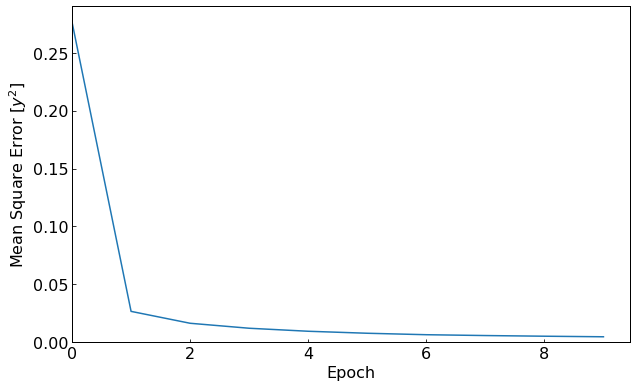

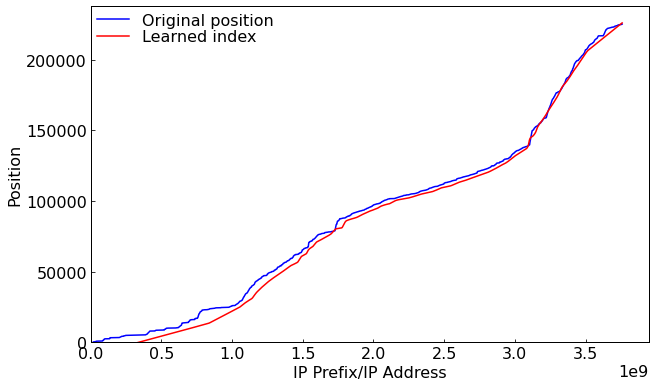

In [47]:
plot_history(history)
plot_result(x_np, y_np, y_pred)

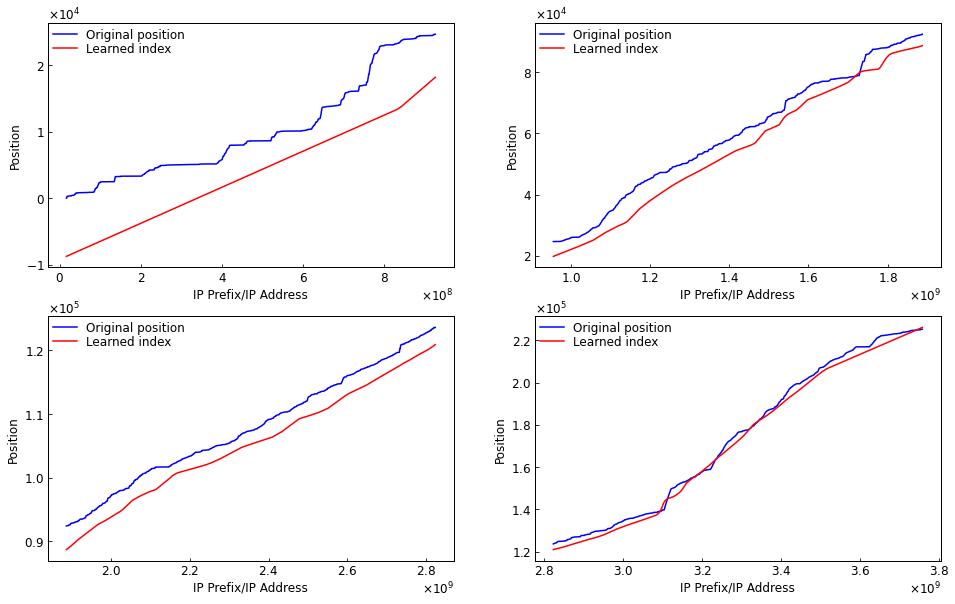

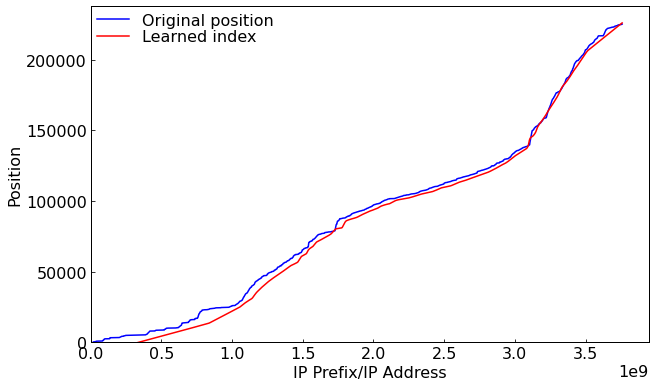

In [50]:
def plot_subfigure(x_orig, y_orig, y_pred, div=(2, 3)):
    figure_width = 16
    figure_height = figure_width / 1.6180
    marker_size = 10
    line_width = 2
    plt.rcParams["font.size"] = 12
    plt.rcParams["xtick.direction"] = "in"
    plt.rcParams["ytick.direction"] = "in"
    plt.rcParams["axes.linewidth"] = 1.0
    plt.rcParams["pdf.fonttype"] = 42

    fig = plt.figure(figsize=(figure_width, figure_height))

    num_figure = div[0] * div[1]

    x_min = np.min(x_orig)
    x_max = np.max(x_orig)

    x_diff  = x_max - x_min
    x_delta = x_diff / num_figure
    
    for i in range(num_figure):
   
        left = (x_delta * i) + x_min
        right = (x_delta * (i + 1)) + x_min

        ind = (left <= x_orig) & (x_orig <= right)

        x1 = x_orig[ind]
        y1 = y_orig[ind]
        y2 = y_pred[ind]

        ax = fig.add_subplot(div[0], div[1], i + 1)

        ax.plot(x1, y1, "b-", label="Original position")
        ax.plot(x1, y2, "r-", label="Learned index")

        # ax.set_xlim(0,)
        # ax.set_ylim(0,)
        ax.set_ylabel("Position")
        ax.set_xlabel("IP Prefix/IP Address")
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci", axis="both", scilimits=(0,0))

        ax.legend(
            loc="upper left",
            frameon=False,
            borderaxespad=0,
            labelspacing=0.1,
        )

plot_subfigure(x_np, y_np, y_pred, div=(2, 2))
plot_result(x_np, y_np, y_pred)